In [1]:
import numpy as np
import pandas as pd
import math

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('D:/Papers/paper_code/new/Data/Processed/Energy_data.csv')

In [3]:
data.head()

,Timestamp,Value,Year,Month,Day,Hour,Minute,timing,week_info,Holiday,lag_tem,lag_value
0,2017-07-25 03:15:00,0.052632,0.0,0.0,0.827586,0.130435,0.333333,0.000000,0.0,0.0,0.322447,0.105263
1,2017-07-25 03:30:00,0.157895,0.0,0.0,0.827586,0.130435,0.666667,0.000000,0.0,0.0,0.300475,0.052632
2,2017-07-25 03:45:00,0.105263,0.0,0.0,0.827586,0.130435,1.000000,0.000000,0.0,0.0,0.278504,0.105263
3,2017-07-25 04:00:00,0.157895,0.0,0.0,0.827586,0.173913,0.000000,0.333333,0.0,0.0,0.256532,0.052632
4,2017-07-25 04:15:00,0.105263,0.0,0.0,0.827586,0.173913,0.333333,0.333333,0.0,0.0,0.255938,0.105263


In [4]:
train = data[:-300]
test = data[-300:]
print(train.shape)
print(test.shape)

(2104, 12)
(300, 12)


In [5]:
x_train = train.drop(columns = {'Timestamp','Value'}, axis = 1)
y_train = train.loc[:, ['Value']]

x_test = test.drop(columns = {'Timestamp','Value'}, axis = 1)
y_test = test.loc[:, ['Value']]

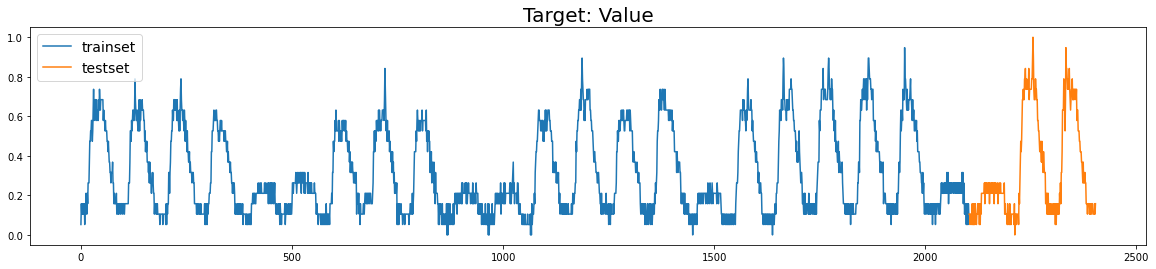

In [6]:
sns.reset_orig()
plt.figure(figsize = (20,4))
plt.title('Target: Value', fontsize = 20)
plt.plot(y_train['Value'], label = 'trainset')
plt.plot(y_test['Value'], label = 'testset')

plt.legend(fontsize = 14)
plt.show()

# LightGBM

In [7]:
import lightgbm as lgb

In [8]:
model = lgb.LGBMRegressor().fit(x_train, y_train)

pred = model.predict(x_test)
r2 = r2_score(pred, y_test)
mse = mean_squared_error(pred, y_test)

print('R2: ', r2, '  ;  ', 'MSE: ', mse)

R2:  0.8290404188221164   ;   MSE:  0.007152391808099926


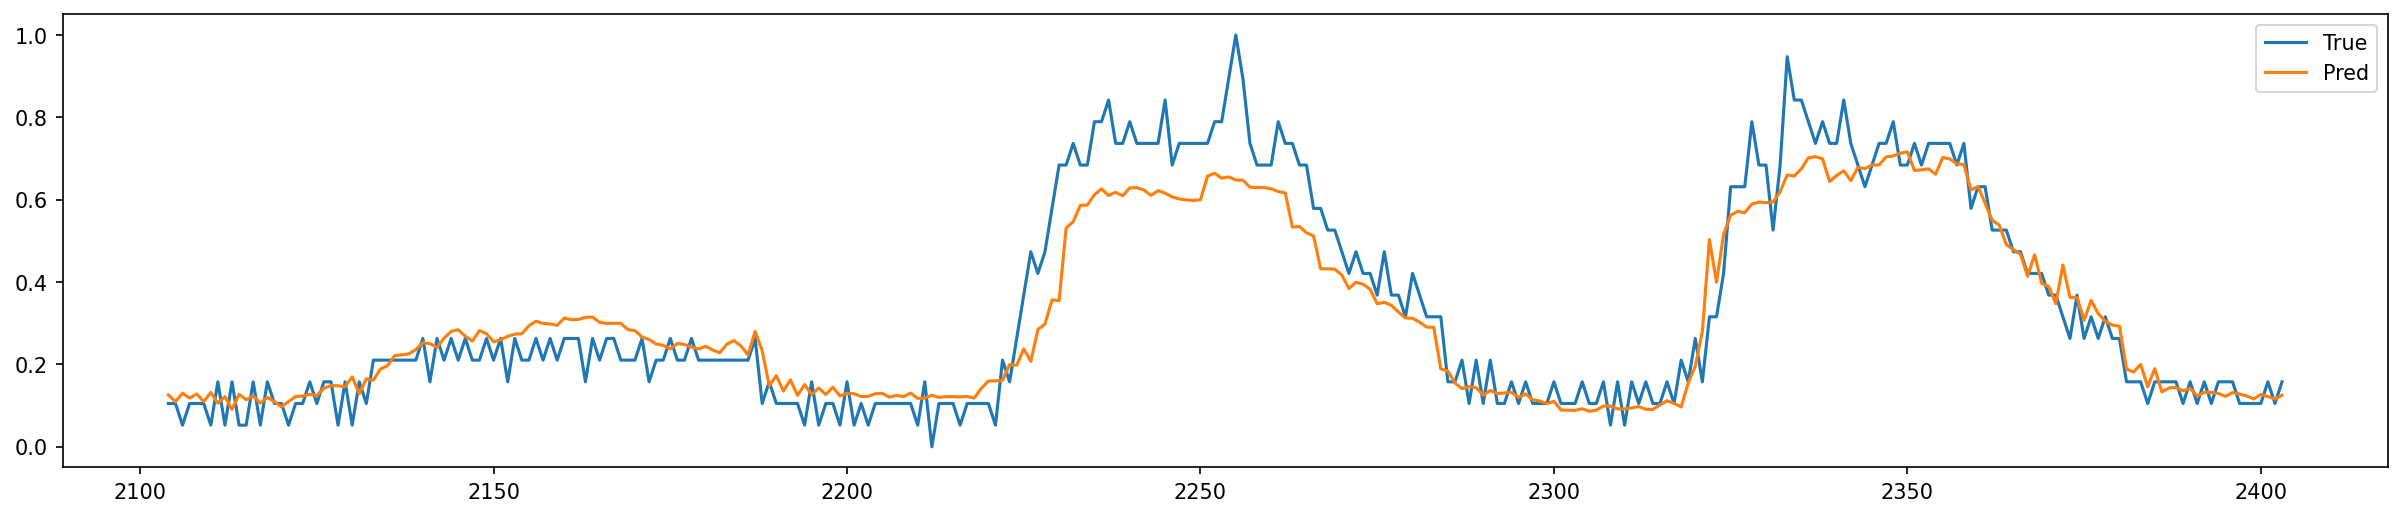

In [9]:
prediction = pd.DataFrame(pred, index=y_test.index)

sns.reset_orig()
plt.figure(figsize = (20,4), dpi=150)

plt.plot(y_test['Value'], label = 'True')
plt.plot(prediction, label = 'Pred')

plt.legend()

plt.show()

# Interpretation of LightGBM

In [10]:
import ShapTimeBoosting
from ShapTimeBoosting import supertime, ShapleyValues, TimeImportance, TimeHeatmap

In [11]:
# The training set is evenly divided into 11 parts in the time dimension, 
# and the importance of each part is calculated.
Tn= 9
interp_x= x_train
model = model

ShapTime_lgb = ShapleyValues(model, interp_x, Tn)

In [12]:
ShapTime_lgb

[0.024793105240528017,
 -0.01622209793167623,
 -0.017859374906695213,
 -0.010673002039594547,
 -0.03012973680371826,
 0.032964294278707965,
 -0.022159502015633548,
 0.0395391014144915,
 0.00036495905459321367]

In [13]:
# name these time periods
time_columns =  ['t0', 't1', 't2', 't3', 't4', 't5', 't6', 't7', 't8']

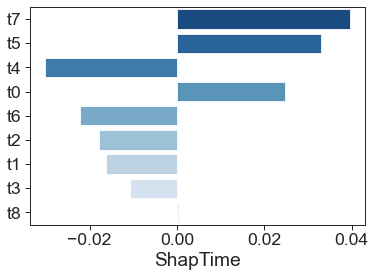

In [14]:
TimeImportance(Tn, ShapTime_lgb, time_columns)

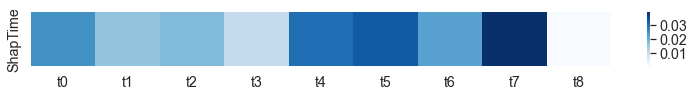

In [15]:
TimeHeatmap(Tn, ShapTime_lgb, time_columns)

# Evaluation of Interpretation

### Feature-Independence

In [16]:
import EvaluationBoosting
from ShapTimeBoosting import FeaIndepenVal, PlotVal

In [17]:
n = 2
Tn = 9
x_train_val = x_train.copy()
y_train = y_train
initial = ShapTime_lgb
model = lgb.LGBMRegressor()

In [18]:
result = FeaIndepenVal(x_train_val, y_train, initial, model, Tn, n, time_columns)

In [19]:
result

,t0,t1,t2,t3,t4,t5,t6,t7,t8
0,0.024793,-0.016222,-0.017859,-0.010673,-0.03013,0.032964,-0.02216,0.039539,0.000365
1,0.024793,-0.016222,-0.017859,-0.010673,-0.03013,0.032964,-0.02216,0.039539,0.000365
2,0.024793,-0.016222,-0.017859,-0.010673,-0.03013,0.032964,-0.02216,0.039539,0.000365


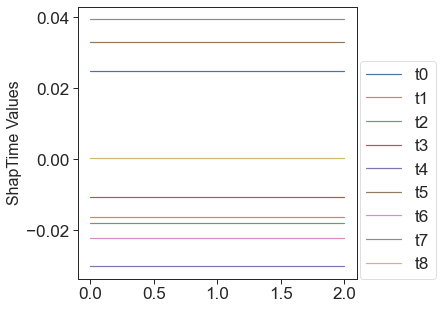

In [20]:
PlotVal(result)

### Sensitivity

In [21]:
situation_0 = [0, 1, 2, 3, 4, 5, 6, 7, 8]
situation_1 = [5, 1, 2, 3, 4, 5, 6, 8, 8]
situation_2 = [5, 4, 2, 3, 4, 3, 6, 8, 8]

In [22]:
total = [situation_0, situation_1, situation_2]
train_eva = train.drop(columns = 'Timestamp')
df_eva = supertime(9, train_eva)
model_eva = lgb.LGBMRegressor()

In [23]:
import EvaluationBoosting
from EvaluationBoosting import evaluation, R2Plot, MSEPlot

In [24]:
r2_results, mse_results = evaluation(df_eva, x_train, y_train, 'Value', model_eva, total)

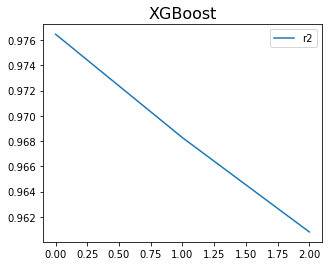

In [25]:
R2Plot(r2_results, 'XGBoost')

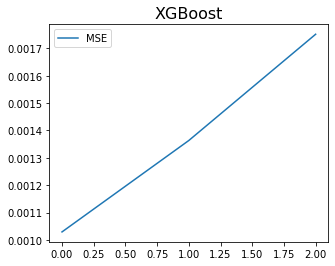

In [26]:
MSEPlot(mse_results, 'XGBoost')

# Improvement

In [27]:
for k in range(Tn):
    exec(f't{k} = supertime(Tn, train)[k]')

In [28]:
check_replist = [t0, t1, t2, t3, t4, t5, t6, t7, t7]

In [29]:
#check
check = pd.concat(check_replist, axis = 0)
x_check = check.drop(columns = {'Timestamp','Value'}, axis = 1)
y_check = check.loc[:, ['Value']]

model_check = lgb.LGBMRegressor().fit(x_check, y_check)

pred_check = model_check.predict(x_test)
r2_check = r2_score(pred_check, y_test)
mse_check = mean_squared_error(pred_check, y_test)

print(r2_check, 'Degree of Improvement: {:.2%}'.format((r2_check-r2)/abs(r2)))
print(mse_check, 'Degree of Improvement: {:.2%}'.format((mse-mse_check)/mse))

0.8444981748766243 Degree of Improvement: 1.86%
0.006946525944174026 Degree of Improvement: 2.88%


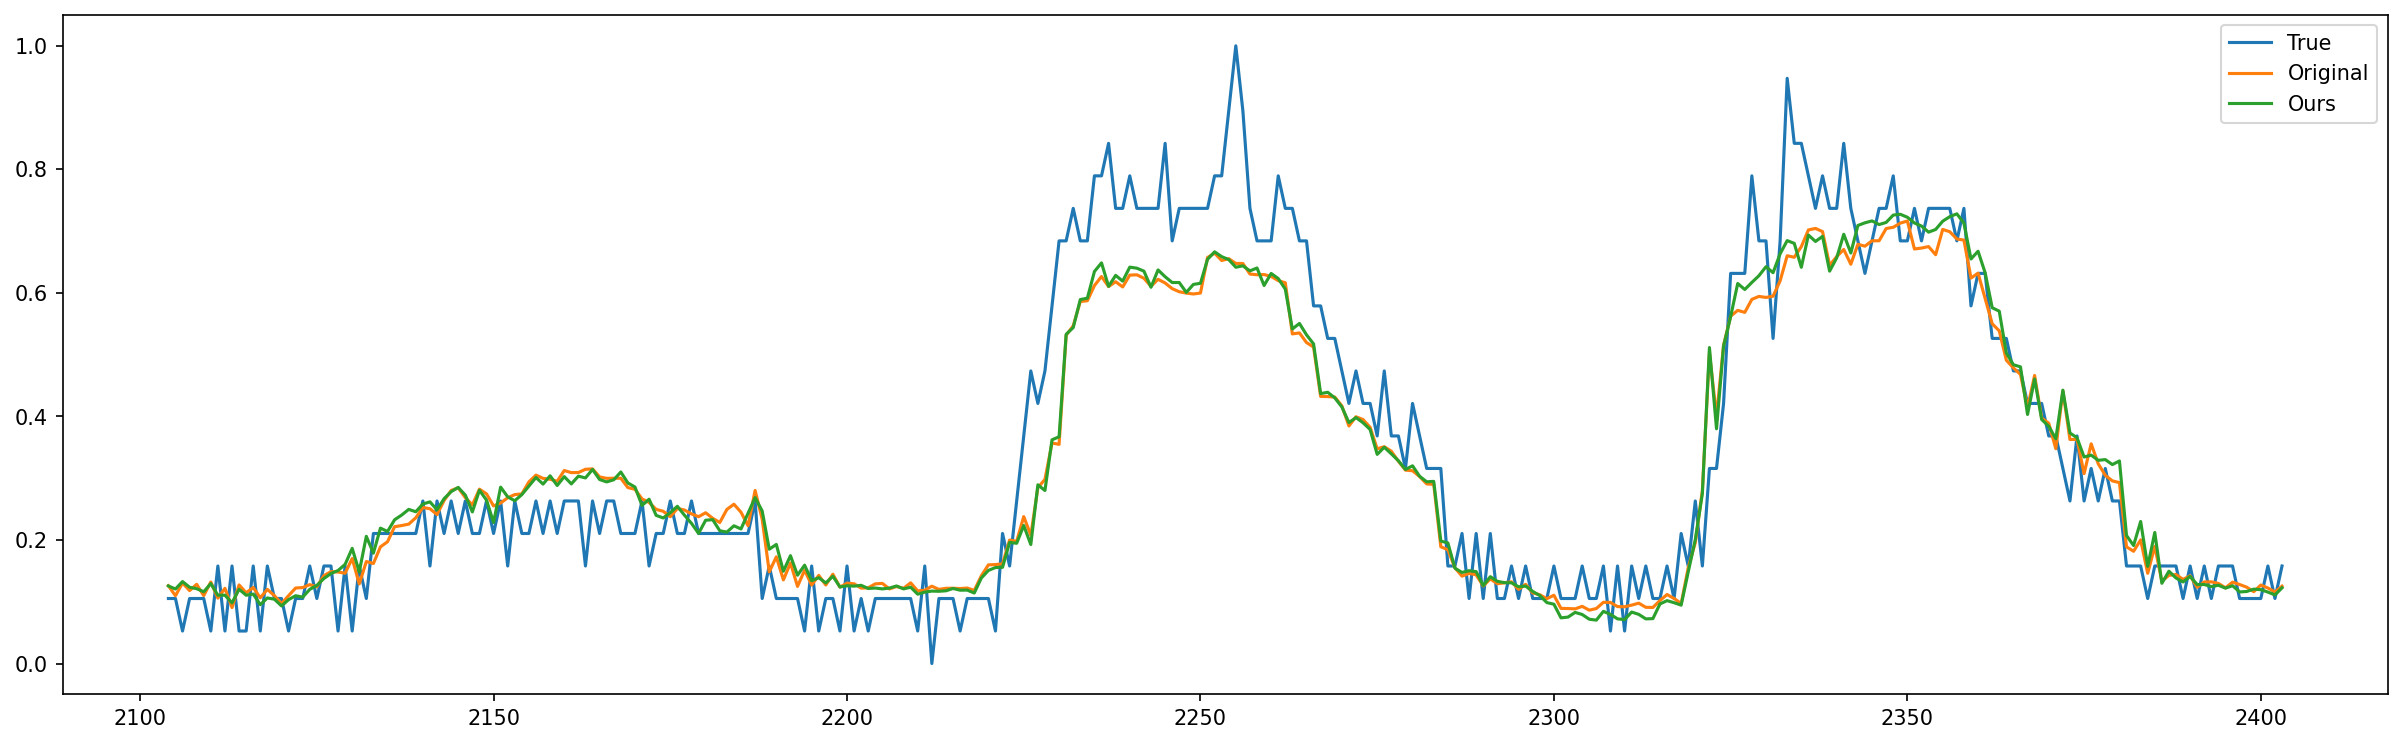

In [30]:
pred_our = pd.DataFrame(pred_check, index=y_test.index)

sns.reset_orig()
plt.figure(figsize = (20,6), dpi=150)

plt.plot(y_test['Value'], label = 'True')
plt.plot(prediction, label = 'Original')
plt.plot(pred_our, label = 'Ours')

plt.legend(fontsize = 10)
plt.show()